In [44]:
from fsl_mrs.utils import mrs_io
import numpy as np
from matplotlib import pyplot as plt
import ants
import re
import pandas as pd

In [150]:
def read_lcm_values(fn):  # {{{
    series_type = None

    series_data = {}
    metabolites = []
    with open(fn) as f:
        vals = []

        for line in f:
            prev_series_type = series_type
            if re.match(".*[0-9]+ points on ppm-axis = NY.*", line):
                series_type = "ppm"
            elif re.match(".*NY phased data points follow.*", line):
                series_type = "data"
            elif re.match(".*NY points of the fit to the data follow.*", line):
                series_type = "completeFit"
                # completeFit implies baseline+fit
            elif re.match(".*NY background values follow.*", line):
                series_type = "baseline"
            elif re.match(".*lines in following.*", line):
                #pattern = r"^\s*(\d+)"
                #number_of_lines = int(re.search(pattern,line).group(1))
                #line_number = 0
                word_pattern = r"lines in following (\w+)"
                series_type = re.search(word_pattern, line).group(1)
                read_table = True
            elif re.match("[ ]+[a-zA-Z0-9]+[ ]+Conc. = [-+.E0-9]+$", line):
                metab = (re.match("[ ]+([a-zA-Z0-9]+)[ ]+Conc. = ([-+.E0-9]+)$", line)).groups(0)[0]
                metabolites.append(metab)
                series_type = f'{metab} spectrum'
    
            if prev_series_type != series_type:  # start/end of chunk...
                if len(vals) > 0:
                    if read_table and prev_series_type=='concentration':
                        # Regular expression pattern to match the data in each line
                        pattern = r"\s*(\S+)\s+(\S+)\s+(\S+)\s+(\S+)"
                        
                        # Extracting information into a list of dicts
                        data = []
                        for line in vals[1:]:  # Skip the header line
                            match = re.match(pattern, line)
                            if match:
                                conc, sd, cr_pc, metabolite = match.groups()
                                data.append({
                                    'Conc.': conc,
                                    '%SD': sd.rstrip('%'),
                                    '/Cr+PCr': cr_pc,
                                    'Metabolite': metabolite
                                })
                        
                        # Creating a DataFrame
                        df = pd.DataFrame(data)#.asytype('float')
                        df['Conc.']=df['Conc.'].astype('float')
                        df['%SD']=df['%SD'].astype('float')
                        df['/Cr+PCr']=df['/Cr+PCr'].astype('float')
                        
                        series_data[prev_series_type] = df
                        reat_table = False
                    elif read_table:
                        series_data[prev_series_type] = vals
                        reat_table = False
                    else:
                        series_data[prev_series_type] = np.array(vals)
                    vals = []
            else:
                if series_type:
                    if read_table:
                        vals.append(line)
                    else:
                        for x in re.finditer(r"([-+.E0-9]+)[ \t]*", line):
                            v = x.group(1)
                            try:
                                v = float(v)
                                vals.append(v)
                            except ValueError:
                                print("Error parsing line: %s" % (line,))
                                print(v)
    series_data['metabolites'] = metabolites
    return series_data
    # }}}

  

# Comparing LCmodel and FLS MRS fits for SWS MRS and dMRS data

Here, I want to compare output values of spectral fits of both softwares to establish a good comparison.

In [282]:
lcmodel_res_sub1_sess1 = read_lcm_values('/home/malte/Documents/Projects/dMRS_starting_data_cristina/CristinasTestData/TheirFolder/Data/NotToShare/quantified/SUM_Bruker_2022-10-31_22_1_ser_processed.lcm/SUM_Bruker_2022-10-31_22_1_ser_processed.COORD')

In [283]:
fslmrs_res_sub1_sess1 = pd.read_csv('/home/malte/Documents/Projects/dMRS_starting_data_cristina/CristinasTestData/derivatives/analysis_all_models/sub-01/ses-01/dmrs/single_fit/concentrations.txt',skiprows=1)

In [284]:
lcmodel_res_sub1_sess2 = read_lcm_values('/home/malte/Documents/Projects/dMRS_starting_data_cristina/CristinasTestData/TheirFolder/Data/NotToShare/quantified/SUM_Bruker_2022-11-17_29_ser_processed.lcm/SUM_Bruker_2022-11-17_29_ser_processed.COORD')

In [285]:
fslmrs_res_sub1_sess2 = pd.read_csv('/home/malte/Documents/Projects/dMRS_starting_data_cristina/CristinasTestData/derivatives/analysis_all_models/sub-01/ses-02/dmrs/single_fit/concentrations.txt',skiprows=1)

In [286]:
lcmodel_res_sub2_sess1 = read_lcm_values('/home/malte/Documents/Projects/dMRS_starting_data_cristina/CristinasTestData/TheirFolder/Data/NotToShare/quantified/SUM_Bruker_2022-11-02_17_2_ser_processed.lcm/SUM_Bruker_2022-11-02_17_2_ser_processed.COORD')

In [287]:
fslmrs_res_sub2_sess1 = pd.read_csv('/home/malte/Documents/Projects/dMRS_starting_data_cristina/CristinasTestData/derivatives/analysis_all_models/sub-02/ses-01/dmrs/single_fit/concentrations.txt',skiprows=1)

In [288]:
lcmodel_res_sub2_sess2 = read_lcm_values('/home/malte/Documents/Projects/dMRS_starting_data_cristina/CristinasTestData/TheirFolder/Data/NotToShare/quantified/SUM_Bruker_2022-11-18_43_ser_processed.lcm/SUM_Bruker_2022-11-18_43_ser_processed.COORD')

In [289]:
fslmrs_res_sub2_sess2 = pd.read_csv('/home/malte/Documents/Projects/dMRS_starting_data_cristina/CristinasTestData/derivatives/analysis_all_models/sub-02/ses-02/dmrs/single_fit/concentrations.txt',skiprows=1)

In [290]:
lcmodel_res_sub3_sess1 = read_lcm_values('/home/malte/Documents/Projects/dMRS_starting_data_cristina/CristinasTestData/TheirFolder/Data/NotToShare/quantified/SUM_Bruker_2022-11-02_19_1_ser_processed.lcm/SUM_Bruker_2022-11-02_19_1_ser_processed.COORD')

In [291]:
fslmrs_res_sub3_sess1 = pd.read_csv('/home/malte/Documents/Projects/dMRS_starting_data_cristina/CristinasTestData/derivatives/analysis_all_models/sub-03/ses-01/dmrs/single_fit/concentrations.txt',skiprows=1)

In [292]:
lcmodel_ress = [[lcmodel_res_sub1_sess1,lcmodel_res_sub1_sess2],[lcmodel_res_sub2_sess1,lcmodel_res_sub2_sess2],[lcmodel_res_sub3_sess1,]]
fslmrs_ress = [[fslmrs_res_sub1_sess1,fslmrs_res_sub1_sess2],[fslmrs_res_sub2_sess1,fslmrs_res_sub2_sess2],[fslmrs_res_sub3_sess1,]]

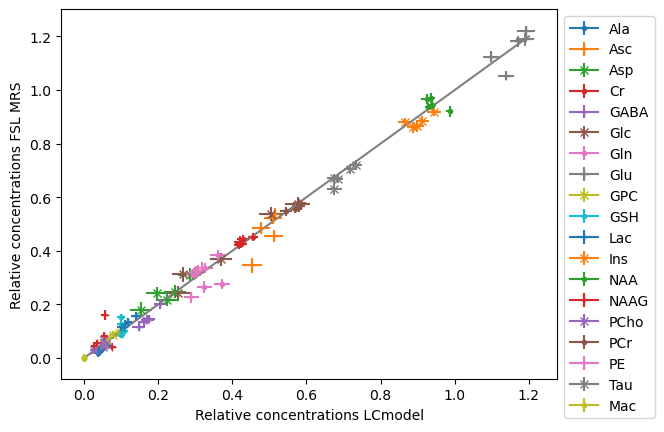

In [293]:
marker=['.', '+', 'x']
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i,metabolite in enumerate(lcmodel_res_sub1_sess1['metabolites']):
    for subj in range(3):
        for sess in range(2):
            if not (subj==2 and sess==1):
                this_lcmodel_res = lcmodel_ress[subj][sess]
                this_fslmrs_res = fslmrs_ress[subj][sess]
                lcmodel_c = this_lcmodel_res['concentration'].loc[this_lcmodel_res['concentration']['Metabolite'] == metabolite, '/Cr+PCr']/8
                lcmodel_c_std = lcmodel_c*.01*this_lcmodel_res['concentration'].loc[this_lcmodel_res['concentration']['Metabolite'] == metabolite, '%SD']
                fslmrs_c = this_fslmrs_res.loc[this_fslmrs_res['Unnamed: 0']==metabolite, 'internal']
                fslmrs_c_std = this_fslmrs_res.loc[this_fslmrs_res['Unnamed: 0']==metabolite, 'internal.1']
                if subj==0 and sess==0:
                    plt.errorbar(x=lcmodel_c, y=fslmrs_c, yerr=fslmrs_c_std, xerr=lcmodel_c_std,label = metabolite,marker=marker[i%3],color=colors[i%10])
                else:
                    plt.errorbar(x=lcmodel_c, y=fslmrs_c, yerr=fslmrs_c_std, xerr=lcmodel_c_std,marker=marker[i%3],color=colors[i%10])

plt.plot([0,1.2],[0,1.2],'gray')
plt.xlabel('Relative concentrations LCmodel')
plt.ylabel('Relative concentrations FSL MRS')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('plots/relative_concentrations_lcmodel_vs_fslmrs.png',bbox_inches='tight')

In [294]:
microstructure_metabolites = ['Ins', 'PCho', 'GPC', 'Cr', 'PCr', 'Glu', 'NAA', 'NAAG']

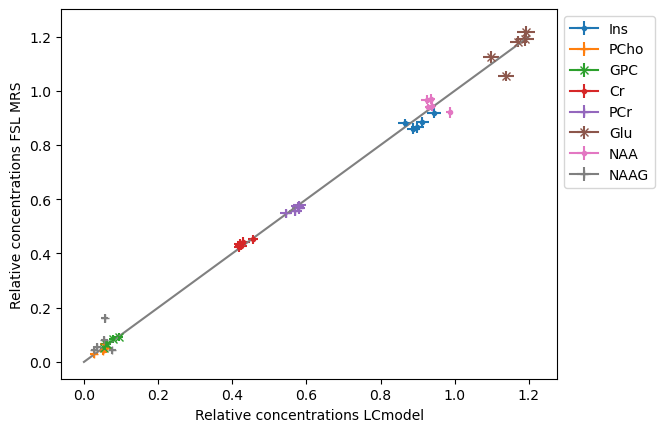

In [295]:
marker=['.', '+', 'x']
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i,metabolite in enumerate(microstructure_metabolites):
    for subj in range(3):
        for sess in range(2):
            if not (subj==2 and sess==1):
                this_lcmodel_res = lcmodel_ress[subj][sess]
                this_fslmrs_res = fslmrs_ress[subj][sess]
                lcmodel_c = this_lcmodel_res['concentration'].loc[this_lcmodel_res['concentration']['Metabolite'] == metabolite, '/Cr+PCr']/8
                lcmodel_c_std = lcmodel_c*.01*this_lcmodel_res['concentration'].loc[this_lcmodel_res['concentration']['Metabolite'] == metabolite, '%SD']
                fslmrs_c = this_fslmrs_res.loc[this_fslmrs_res['Unnamed: 0']==metabolite, 'internal']
                fslmrs_c_std = this_fslmrs_res.loc[this_fslmrs_res['Unnamed: 0']==metabolite, 'internal.1']
                if subj==0 and sess==0:
                    plt.errorbar(x=lcmodel_c, y=fslmrs_c, yerr=fslmrs_c_std, xerr=lcmodel_c_std,label = metabolite,marker=marker[i%3],color=colors[i%10])
                else:
                    plt.errorbar(x=lcmodel_c, y=fslmrs_c, yerr=fslmrs_c_std, xerr=lcmodel_c_std,marker=marker[i%3],color=colors[i%10])

plt.plot([0,1.2],[0,1.2],'gray')
plt.xlabel('Relative concentrations LCmodel')
plt.ylabel('Relative concentrations FSL MRS')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('plots/relative_concentrations_lcmodel_vs_fslmrs_most_relevant_metabolites.png',bbox_inches='tight')